In [183]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import geopandas as gpd
import numpy as np
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FuncFormatter

In [5]:
# Load NetCDF files (update paths/names as needed)
peltier_model = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_PELTIER_ICE6G-D_0.5-DEG_v1.0.nc")
wahr_model = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_A-WAHR_ICE5G-VM2_0.5-DEG_v1.0.nc")
caron_model = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_CARON-2018_0.5-DEG_v1.0.nc")

In [52]:
peltier_mass_rate = peltier_model.GIA_mass_rate_3degJPL_MSCN
peltier_geiod_rate = peltier_model.GIA_geoid_rate_3degJPL_MSCN

caron_mass_rate = caron_model.GIA_mass_rate_3degJPL_MSCN
caron_geiod_rate = caron_model.GIA_geoid_rate_3degJPL_MSCN

wahr_mass_rate = wahr_model.GIA_mass_rate_3degJPL_MSCN
wahr_geiod_rate = wahr_model.GIA_geoid_rate_3degJPL_MSCN

# peltier_mass_rate

<xarray.DataArray 'GIA_mass_rate_3degJPL_MSCN' (lat: 360, lon: 720)> Size: 2MB
[259200 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Attributes:
    long_name:        Glacial Isostatic Adjustment - corrections for GRACE & ...
    valid_min:        -0.01
    valid_max:        0.05
    comment:          Model: ICE-6G_D (VM5a) O(512)
    comment_summary:  Peltier (Ice-6G_D (updated; 06/2017!))
    type:             mass
    units:            m/year

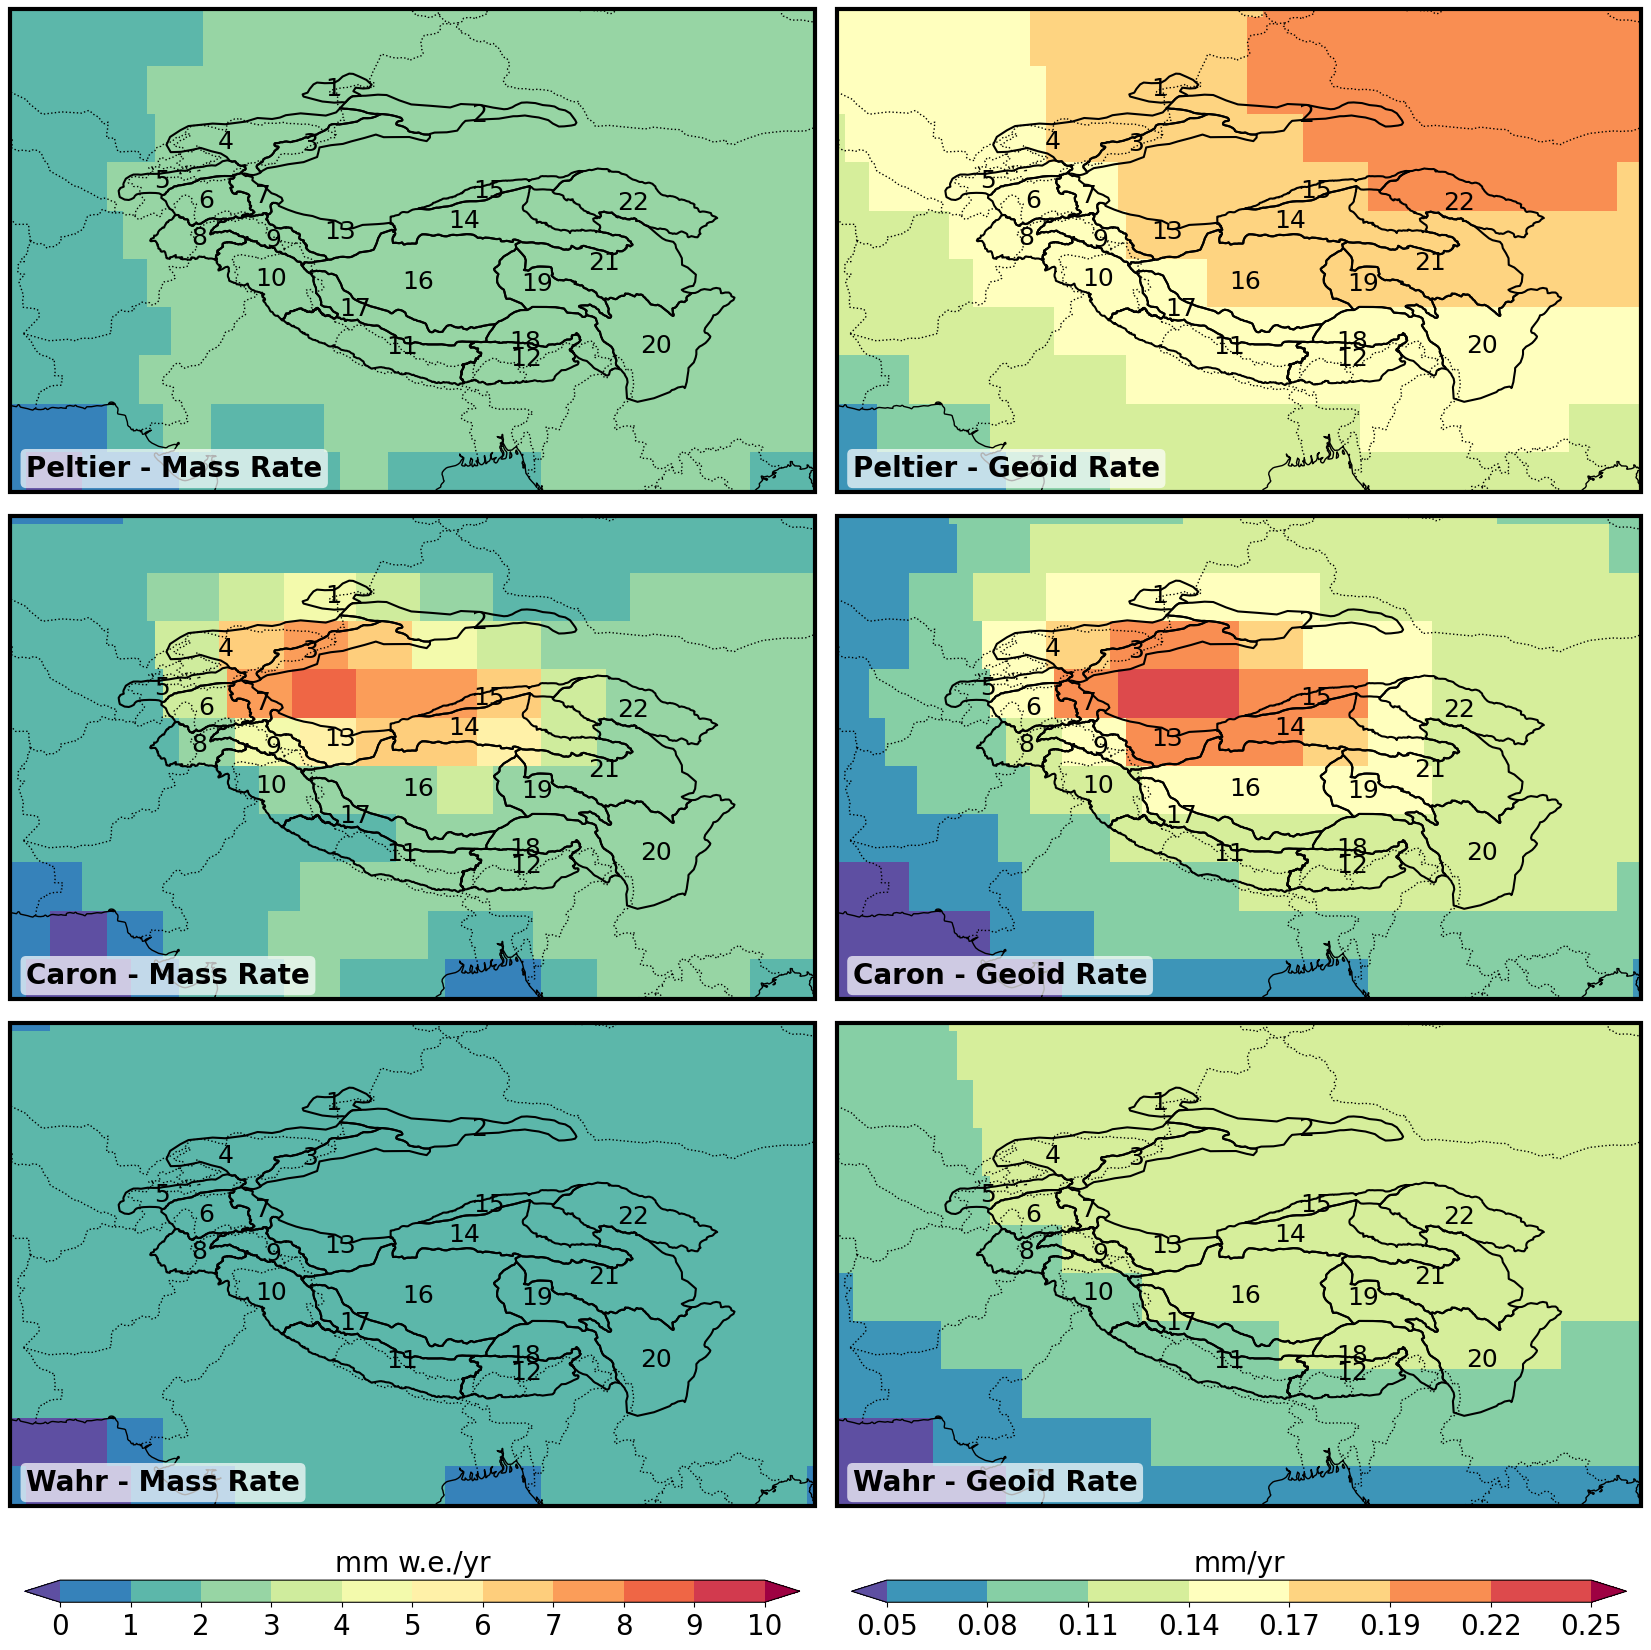

In [187]:
# --- File paths and shapefile ---
hma_shapefile = r'D:\MSRSGI\Masters_thesis\Data\HMA_Region_Shapefiles\Regions_shapefiles\New folder\TotalHMA_boundary1_22.shp'
hma_boundary = gpd.read_file(hma_shapefile).to_crs("EPSG:4326")

# Region of interest (HMA)
lon_min, lon_max = 60, 110
lat_min, lat_max = 20, 50

# --- GIA NetCDF files ---
peltier = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_PELTIER_ICE6G-D_0.5-DEG_v1.0.nc")
caron   = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_CARON-2018_0.5-DEG_v1.0.nc")
wahr    = xr.open_dataset(r"D:\MSRSGI\Masters_thesis\Data\GIA_PGR\Tellus_GIA_L3_A-WAHR_ICE5G-VM2_0.5-DEG_v1.0.nc")


# --- Extract data arrays and convert units (to mm/yr) ---
peltier_mass  = peltier['GIA_mass_rate_3degJPL_MSCN'] * 1000
peltier_geoid = peltier['GIA_geoid_rate_3degJPL_MSCN'] * 1000
caron_mass    = caron['GIA_mass_rate_3degJPL_MSCN'] * 1000
caron_geoid   = caron['GIA_geoid_rate_3degJPL_MSCN'] * 1000
wahr_mass     = wahr['GIA_mass_rate_3degJPL_MSCN'] * 1000
wahr_geoid    = wahr['GIA_geoid_rate_3degJPL_MSCN'] * 1000

# Organize as (mass, geoid, model name)
models = [
    (peltier_mass,  peltier_geoid, 'Peltier'),
    (caron_mass,    caron_geoid,   'Caron'),
    (wahr_mass,     wahr_geoid,    'Wahr')
]

# --- Custom color levels ---
levels_mass = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
levels_geoid = [0.05, 0.08, 0.11, 0.14, 0.17, 0.19, 0.22, 0.25]  # Example for geoid; adjust as needed
cmap_mass = plt.get_cmap("Spectral_r")
cmap_geoid = plt.get_cmap("Spectral_r")
norm_mass = BoundaryNorm(levels_mass, ncolors=cmap_mass.N, extend='both')
norm_geoid = BoundaryNorm(levels_geoid, ncolors=cmap_geoid.N, extend='both')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 24), subplot_kw={'projection': ccrs.PlateCarree()})

im_mass = None
im_geoid = None

for i, (mass_data, geoid_data, model_name) in enumerate(models):
    for j, (rate_data, varname, cmap, norm) in enumerate([
        (mass_data, 'Mass Rate', cmap_mass, norm_mass),
        (geoid_data, 'Geoid Rate', cmap_geoid, norm_geoid)
    ]):
        ax = axes[i, j]

        cropped = rate_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        lons = cropped['lon'].values
        lats = cropped['lat'].values
        data = cropped.values
        lon2d, lat2d = np.meshgrid(lons, lats)
        im = ax.pcolormesh(
            lon2d, lat2d, data,
            cmap=cmap, norm=norm,
            transform=ccrs.PlateCarree(), shading='auto'
        )
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        for geom in hma_boundary.geometry:
            ax.add_geometries([geom], crs=ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1.5)
        for idx, row in hma_boundary.iterrows():
            x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
            region_num = row['Region_No']  # Replace with your region number column name
            ax.text(x, y, str(region_num), fontsize=18, ha='center', va='center', transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        for spine in ax.spines.values():
            spine.set_linewidth(3)
            spine.set_edgecolor('black')  # Set the border color

        # ax.set_title(f"{model_name} - {varname}", fontsize=14, pad=8)
        ax.text(
            0.02, 0.02, f"{model_name} - {varname}",
            transform=ax.transAxes, fontsize=20, fontweight='bold',
            color='black', ha='left', va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2')
        )
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        # Save colorbar mappables
        if j == 0:
            im_mass = im
        else:
            im_geoid = im

# Adjust layout
fig.subplots_adjust(wspace=-0.2, hspace=0.05)


# For the mass rate colorbar (left column)
cbar_mass = fig.colorbar(
    im_mass,
    ax=axes[:, 0],  # All axes in the left column
    orientation='horizontal',
    ticks=levels_mass,
    extend='both',
    pad=0.04,       # Adjust pad for vertical spacing
    aspect=35,
    shrink=0.75
)
cbar_mass.set_label("mm w.e./yr", fontsize=20, labelpad=-65, y=0.5)
cbar_mass.ax.tick_params(labelsize=20)
cbar_mass.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.0f}"))

# For the geoid rate colorbar (right column)
cbar_geoid = fig.colorbar(
    im_geoid,
    ax=axes[:, 1],  # All axes in the right column
    orientation='horizontal',
    ticks=levels_geoid,
    extend='both',
    pad=0.04,
    aspect=35,
    shrink=0.75
)
cbar_geoid.set_label("mm/yr", fontsize=20, labelpad=-65, y=0.5)
cbar_geoid.ax.tick_params(labelsize=20)
cbar_geoid.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

plt.savefig('D:/MSRSGI/Lab Rotation/Physical Geodesy/Python_Workspace/Organaized/Mascon/Combined/Result/Figures/Thesis_Maps/DifferentGIAModels_withMassAndGeiodRate.png', bbox_inches='tight', dpi=500)
plt.show()